This is needed to reload modules without restarting the kernel

In [1]:
%load_ext autoreload
%autoreload 2

This is needed to add eda_tools from the directories above

In [2]:
import os
os.sys.path.append('../../')

In [3]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [50]:
import mplhep as hep
hep.set_style('ATLAS')

In [4]:
from hh4b_utils.nnt_tools import load_nnt

In [304]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [305]:
from sklearn.metrics import auc

In [306]:
from sklearn import tree

### 1D AUC

In [232]:
print(np.arange(0, 3, 0.006).shape)
print(np.linspace(0, 3, int((3/0.006))).shape)

(500,)
(500,)


In [246]:
def auc_1d(SigArray, BkgArray, ncuts:int=100)->float:
    min_cut = np.min(SigArray)
    max_cut = np.max(SigArray)

    iterationset = np.linspace(min_cut,max_cut,ncuts)

    TPR = []
    FPR = []

    for cuti in iterationset:

        BkgCutLess = np.where(BkgArray < cuti)
        SigCutLess = np.where(SigArray < cuti)
        BkgCutMore = np.where(BkgArray > cuti)
        SigCutMore = np.where(SigArray > cuti)

        TP = float(SigCutLess[0].shape[0])
        FN = float(SigCutMore[0].shape[0])

        TN = float(BkgCutMore[0].shape[0])
        FP = float(BkgCutLess[0].shape[0])

        Sens = float(TP / (TP + FN))
        Spec = float(TN / (TN + FP))
        OneMinSpec = float(1-Spec)

        TPR.append(Sens)
        FPR.append(OneMinSpec)


    return auc(FPR, TPR)


In [151]:
auc_1d(signal_df['X_wt_tag'], bkg_df['X_wt_tag'], ncuts=1000)

0.37957417493721274

# Classifier MVA

Lets give the good old classifier a college try

In [5]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         68G         50G        277M        6.3G         54G
Swap:           15G        4.2G         11G


In [6]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/mc

total 6.1G
-rw-r--r-- 1 lborgna users 1.9G Apr 16 15:12 allhad_mc16a_merge.root
drwxr-xr-x 5 lborgna users 4.0K Apr 19 11:21 DEC20_prod
-rw------- 1 lborgna users  80M Apr 28 17:44 mc16a_2b_shiftKR_lshi.root
-rw-r--r-- 1 lborgna users 140M Feb 25 01:22 NanoNTuple.root
-rw-r--r-- 1 lborgna users 3.2G Apr 16 15:16 semilep_mc16a_merge.root
-rw-r--r-- 1 lborgna users  81M Apr 20 18:04 SMNR_600043_2B_SRshift_mc16a_new.root
-rw-r--r-- 1 lborgna users  17M Apr  5 17:28 SMNR_600043_mc16a_2B_SRshift.root
-rw-r--r-- 1 lborgna users  73M Feb 25 02:33 SMNR_600043_mc16a_b.root
-rw-r--r-- 1 lborgna users  73M Mar  2 23:57 SMNR_600043_mc16a.root
-rw-r--r-- 1 lborgna users  25M Apr  5 16:58 SMNR_600043_mc16a_SRshift.root
-rw-r--r-- 1 lborgna users  17M Feb 23 23:28 SMNR_600043_mc16a_two_buckets.root
-rw-r--r-- 1 lborgna users  19M Apr  5 17:28 SMNR_600043_mc16d_2B_SRshift.root
-rw-r--r-- 1 lborgna users  78M Feb 25 02:14 SMNR_600043_mc16d_b.root
-rw-r--r-- 1 lborgna users  78M Mar  2 23:57 SMNR_600043

In [7]:
file_path = "/mnt/storage/lborgna/NNT/MDR_VEC/mc/mc16a_2b_shiftKR_lshi.root"

In [8]:
f = uproot.open(file_path)

In [9]:
df = load_nnt(file_path, trees=['sig'])

100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


In [10]:
df

run_number  event_number  pass_vbf_sel     mc_sf  trig_sf  \
0          301973        286648         False  0.000013      1.0   
1          311170        285509         False  0.000017      1.0   
2          307732        285153         False  0.000018      1.0   
3          307454        286357         False -0.000014      1.0   
4          302872        286133         False  0.000017      1.0   
...           ...           ...           ...       ...      ...   
35841      310247       1225284         False  0.000010      1.0   
35842      307656       1225165         False  0.000014      1.0   
35843      300863       1226557         False  0.000016      1.0   
35844      307619       1225001         False  0.000014      1.0   
35845      303943       1225504         False  0.000014      1.0   

       jet_trig_sfs     truth_mhh  ntag  njets  kinematic_region  ...  \
0               1.0  4.037929e+05     3      4                 0  ...   
1               1.0  5.257404e+05     3      4                 0  ...   
2               1.0  5.394697e+05     4      4                 0  ...   
3               1.0  6.484571e+05     3      4                 0  ...   
4               1.0  6.642324e+05     3      4                 0  ...   
...             ...           ...   ...    ...               ...  ...   
35841           1.0  6.670061e+05     3      4                 0  ...   
35842           1.0  7.807215e+05     4      7                 0  ...   
35843           1.0  4.763259e+05     4      5                 0  ...   
35844           1.0  4.530388e+05     4      4                 0  ...   
35845           1.0  1.007818e+06     4      5                 0  ...   

       tagged_vbf_j1  m_vbf_j2    E_vbf_j2   pT_vbf_j2  eta_vbf_j2  \
0              False  0.000000    0.000000    0.000000    0.000000   
1              False  0.000000    0.000000    0.000000    0.000000   
2              False  0.000000    0.000000    0.000000    0.000000   
3              False  0.000000    0.000000    0.000000    0.000000   
4              False  0.000000    0.000000    0.000000    0.000000   
...              ...       ...         ...         ...         ...   
35841          False  8.459204  689.301819   42.479042    3.478789   
35842          False  9.449975  800.583984  103.324669    2.736352   
35843          False  0.614368  667.623047   77.104393    2.848359   
35844          False  0.000000    0.000000    0.000000    0.000000   
35845          False  0.000000    0.000000    0.000000    0.000000   

       phi_vbf_j2  tagged_vbf_j2      vbf_mjj  vbf_dEtajj  vbf_pTvecsum  
0        0.000000          False     0.000000    0.000000      0.000000  
1        0.000000          False     0.000000    0.000000      0.000000  
2        0.000000          False     0.000000    0.000000      0.000000  
3        0.000000          False     0.000000    0.000000      0.000000  
4        0.000000          False     0.000000    0.000000      0.000000  
...           ...            ...          ...         ...           ...  
35841    2.708029          False  1317.633571    6.784838     90.276637  
35842    1.218975          False  2349.941059    5.288846    178.011778  
35843   -0.482535          False   700.442181    3.784084     17.428529  
35844    0.000000          False     0.000000    0.000000      0.000000  
35845    0.000000          False     0.000000    0.000000      0.000000  

[35846 rows x 89 columns]

In [11]:
features = ['Xhh','dEta_hh','njets','X_wt_tag']

In [12]:
def Xhh(m1, m2, m_h1_center=120, m_h2_center=110):
    return np.sqrt(
        ((m1 - m_h1_center) / (0.1 * m1)) ** 2 + ((m2 - m_h2_center) / (0.1 * m2)) ** 2
    )

In [13]:
df['Xhh'] = Xhh(df.m_h1, df.m_h2, m_h1_center=124, m_h2_center=117)

In [14]:
(df['Xhh'] > 1.6).value_counts()

False    35846
Name: Xhh, dtype: int64

In [15]:
!ls -lh /mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root

-rw-r--r-- 1 lborgna users 509M Apr 22 04:01 /mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root


In [16]:
data = load_nnt('/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root', trees=['sig'])

100%|██████████| 141/141 [00:25<00:00,  5.45it/s]


In [58]:
data = data[~data['pass_vbf_sel']].reset_index(drop=True)

In [61]:
df = df[~df['pass_vbf_sel']].reset_index(drop=True)

In [62]:
from hh4b_utils.nnt_tools import get_mu,w_col

In [63]:
f = uproot.open('/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps.root')

In [64]:
norm = get_mu(f)

In [65]:
data['Xhh'] = Xhh(data['m_h1'], data['m_h2'], m_h1_center=124, m_h2_center=117)

In [66]:
df.kinematic_region.value_counts()

0    35359
Name: kinematic_region, dtype: int64

In [67]:
signal_df = df.loc[df['ntag']>=4].reset_index(drop=True)

In [68]:
signal_df.kinematic_region.value_counts()

0    21617
Name: kinematic_region, dtype: int64

In [69]:
signal_df['sample_weight'] = signal_df['mc_sf']
signal_df['sample_weight2'] = 1

In [70]:
bkg_df = data.loc[data['ntag']==2].reset_index(drop=True)

In [71]:
bkg_df['NN_weights'] = norm * bkg_df['NN_d24_weight_bstrap_med_16']

In [72]:
bkg_df['sample_weight'] = bkg_df['NN_weights']
bkg_df['sample_weight2'] = bkg_df['NN_weights']

In [73]:
bkg_df['class'] = 0

In [74]:
signal_df['class'] = 1

In [75]:
df_data = pd.concat([signal_df, bkg_df], ignore_index=True)

In [76]:
df_data

run_number  event_number  pass_vbf_sel     mc_sf  trig_sf  \
0           307732        285153         False  0.000018      1.0   
1           307354        286651         False -0.000013      1.0   
2           310468        285723         False -0.000010      1.0   
3           304198        286574         False  0.000014      1.0   
4           304128        286945         False  0.000017      1.0   
...            ...           ...           ...       ...      ...   
415519      310809    3067103461         False  1.000000      1.0   
415520      310809    2063588288         False  1.000000      1.0   
415521      310809    1313567219         False  1.000000      1.0   
415522      310809    1313868051         False  1.000000      1.0   
415523      310809    1919891579         False  1.000000      1.0   

        jet_trig_sfs      truth_mhh  ntag  njets  kinematic_region  ...  \
0                1.0  539469.686412     4      4                 0  ...   
1                1.0  520006.020530     4      4                 0  ...   
2                1.0  612553.782663     4      5                 0  ...   
3                1.0  549449.184280     4      4                 0  ...   
4                1.0  450522.895701     4      5                 0  ...   
...              ...            ...   ...    ...               ...  ...   
415519           1.0       0.000000     2      4                 0  ...   
415520           1.0       0.000000     2      5                 0  ...   
415521           1.0       0.000000     2      4                 0  ...   
415522           1.0       0.000000     2      4                 0  ...   
415523           1.0       0.000000     2      5                 0  ...   

        class  NN_d24_weight_bstrap_med_16  NN_d24_weight_bstrap_perc_25_16  \
0           1                          NaN                              NaN   
1           1                          NaN                              NaN   
2           1                          NaN                              NaN   
3           1                          NaN                              NaN   
4           1                          NaN                              NaN   
...       ...                          ...                              ...   
415519      0                     0.003736                         0.003118   
415520      0                     0.012392                         0.009065   
415521      0                     0.002782                         0.002027   
415522      0                     0.003958                         0.003282   
415523      0                     0.021107                         0.017891   

        NN_d24_weight_bstrap_perc_75_16  NN_d24_weight_bstrap_IQR_16  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   
...                                 ...                          ...   
415519                         0.004332                     0.001215   
415520                         0.016190                     0.007125   
415521                         0.003381                     0.001354   
415522                         0.005257                     0.001974   
415523                         0.025305                     0.007414   

        NN_d24_weight_VRderiv_bstrap_med_16  \
0                                       NaN   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
...                                     ...   
415519                             0.004319   
415520                             0.009718   
415521                             0.0017

In [234]:
from eda_tools.utilities import calculatedRhh

In [235]:
calculatedRhh(df_data)

In [241]:
calculatedRhh(signal_df)

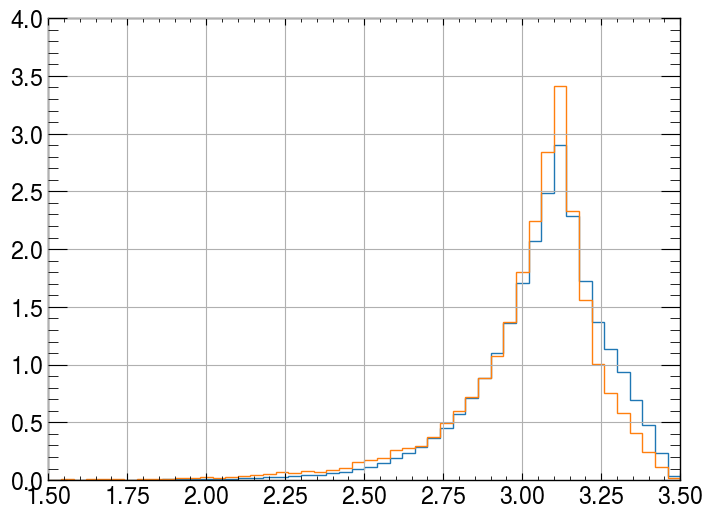

In [244]:
df_data['dR_hh'].hist(histtype='step', density = True,range=(1.5, 3.5),bins=50)
signal_df['dR_hh'].hist(histtype='step',density=True, range=(1.5, 3.5),bins=50)

In [229]:
bkg_df.shape

[autoreload of seaborn.external.six failed: Traceback (most recent call last):
  File "/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 287, in update_class
    old_obj = getattr(old, key)
  File "/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/seaborn/external/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of seaborn.relatio

(393907, 102)

In [230]:
signal_df.shape

(21617, 93)

In [231]:
393907/21617

18.22209372253319

In [ ]:
_ = plt.hist(signal_df.)

# Analyze features

**RAW FEATURES**

Text(0, 0.5, 'arb.units')

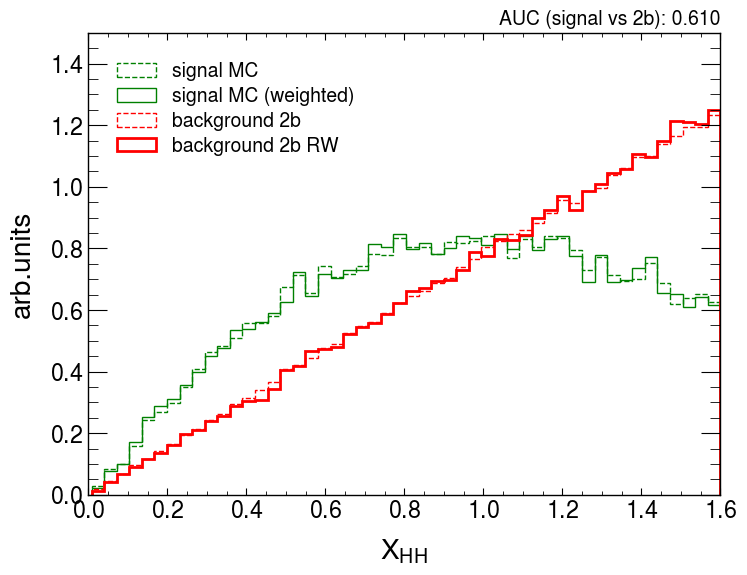

In [131]:
h_sig_raw, be, _ = plt.hist(
    signal_df["Xhh"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)

h_sig_w, be, _ = plt.hist(
    signal_df["Xhh"].values,
    bins=50,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["Xhh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["Xhh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)

auc_raw = auc_1d(signal_df['Xhh'],bkg_df['Xhh'])
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
plt.legend(loc='upper left')
plt.ylim(0,1.5)
plt.xlabel('$X_{HH}$')
plt.ylabel('arb.units')

Text(0, 0.5, 'arb.units')

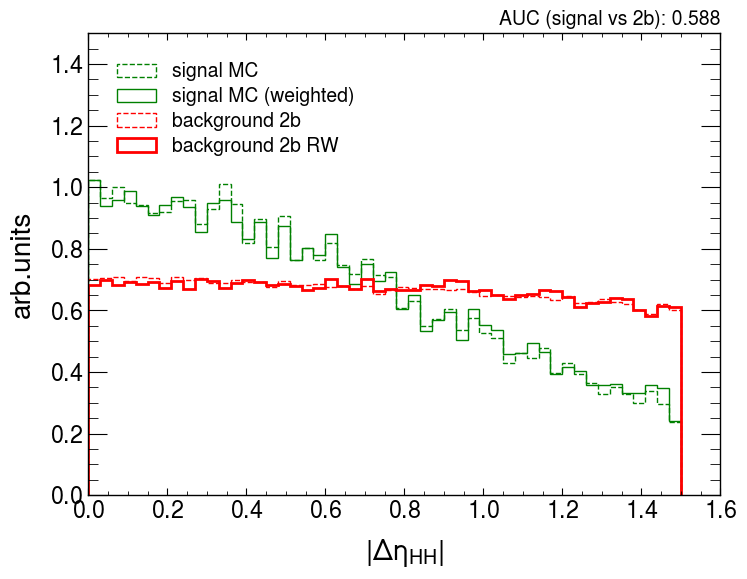

In [132]:
h_sig_raw, be, _ = plt.hist(
    signal_df["dEta_hh"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, be, _ = plt.hist(
    signal_df["dEta_hh"].values,
    bins=50,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["dEta_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["dEta_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)

auc_raw = auc_1d(signal_df['dEta_hh'],bkg_df['dEta_hh'])
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
plt.legend(loc='upper left')
plt.ylim(0,1.5)
plt.xlabel('$|\Delta \eta_{HH}|$')
plt.ylabel('arb.units')

In [93]:
be_njets=[3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5]

Text(0, 0.5, 'arb.units')

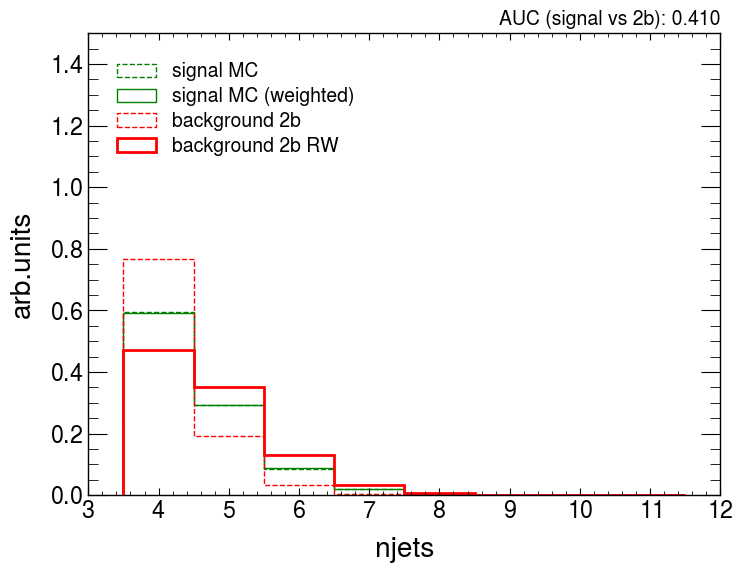

In [137]:
h_sig_raw, be, _ = plt.hist(
    signal_df["njets"].values,
    bins=be_njets,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, _, _ = plt.hist(
    signal_df["njets"].values,
    bins=be,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["njets"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["njets"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)

auc_raw = auc_1d(signal_df['njets'],bkg_df['njets'],ncuts=10)
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
plt.legend(loc='upper left')
plt.ylim(0,1.5)
plt.xlabel('njets')
plt.ylabel('arb.units')

Text(0, 0.5, 'arb.units')

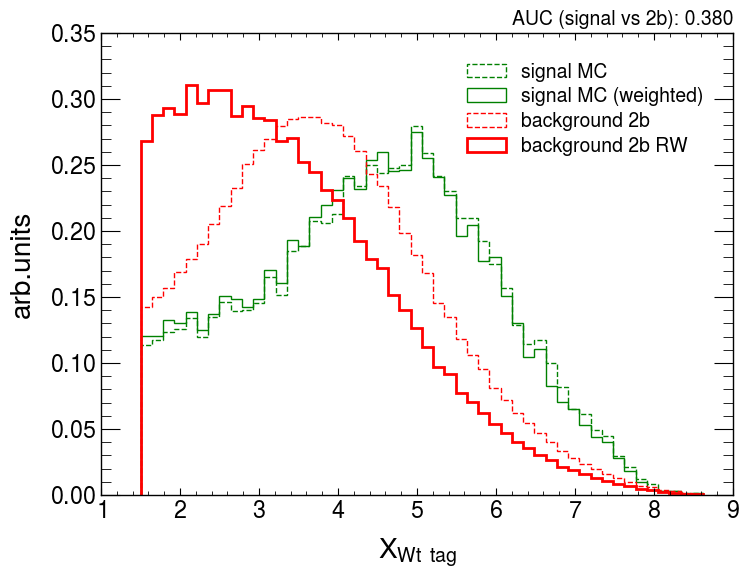

In [153]:
h_sig_raw, be, _ = plt.hist(
    signal_df["X_wt_tag"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, _, _ = plt.hist(
    signal_df["X_wt_tag"].values,
    bins=be,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["X_wt_tag"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["X_wt_tag"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)
auc_raw = auc_1d(signal_df['X_wt_tag'],bkg_df['X_wt_tag'],ncuts=100)

# clf = tree.DecisionTreeClassifier()
# X = np.append(signal_df['X_wt_tag'].values, bkg_df['X_wt_tag'].values).reshape(-1,1)
# y = np.append(np.ones(signal_df.shape[0]), np.zeros(bkg_df.shape[0])).reshape(-1,1)
# w = np.append(np.ones(signal_df.shape[0]), bkg_df['NN_weights'].values)
# clf = clf.fit(X, y, sample_weight=w)
# auc = roc_auc_score(y, clf.predict_proba(X)[:,1], sample_weight=w)
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
# plt.title("AUC (signal vs 2b RW): {:.3f}".format(auc), loc='right', fontsize=14)
plt.legend(loc='best')
plt.xlabel(r'$X_{Wt\,\,\,  tag}$')
plt.ylabel('arb.units')

Text(0, 0.5, 'arb.units')

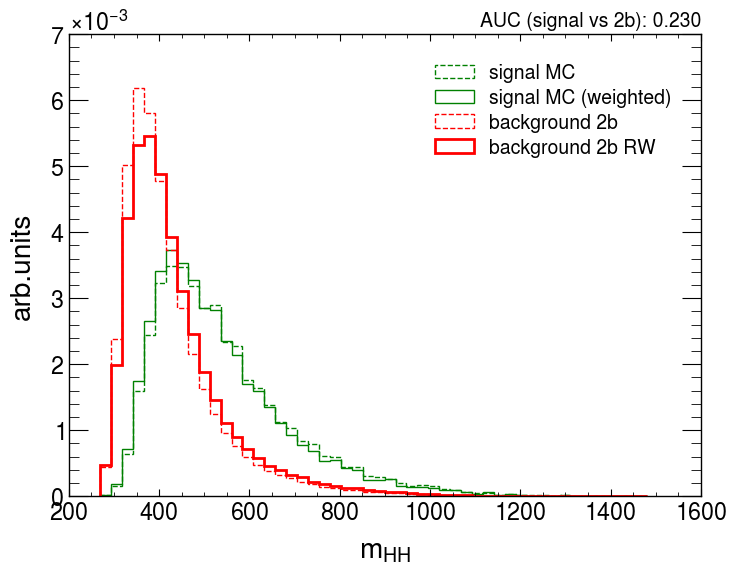

In [307]:
h_sig_raw, be, _ = plt.hist(
    signal_df["m_hh"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, _, _ = plt.hist(
    signal_df["m_hh"].values,
    bins=be,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["m_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["m_hh"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)
auc_raw = auc_1d(signal_df['m_hh'],bkg_df['m_hh'],ncuts=100)

# clf = tree.DecisionTreeClassifier()
# X = np.append(signal_df['X_wt_tag'].values, bkg_df['X_wt_tag'].values).reshape(-1,1)
# y = np.append(np.ones(signal_df.shape[0]), np.zeros(bkg_df.shape[0])).reshape(-1,1)
# w = np.append(np.ones(signal_df.shape[0]), bkg_df['NN_weights'].values)
# clf = clf.fit(X, y, sample_weight=w)
# auc = roc_auc_score(y, clf.predict_proba(X)[:,1], sample_weight=w)
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
# plt.title("AUC (signal vs 2b RW): {:.3f}".format(auc), loc='right', fontsize=14)
plt.legend(loc='best')
plt.xlabel(r'$m_{HH}$')
plt.ylabel('arb.units')

Text(0, 0.5, 'arb.units')

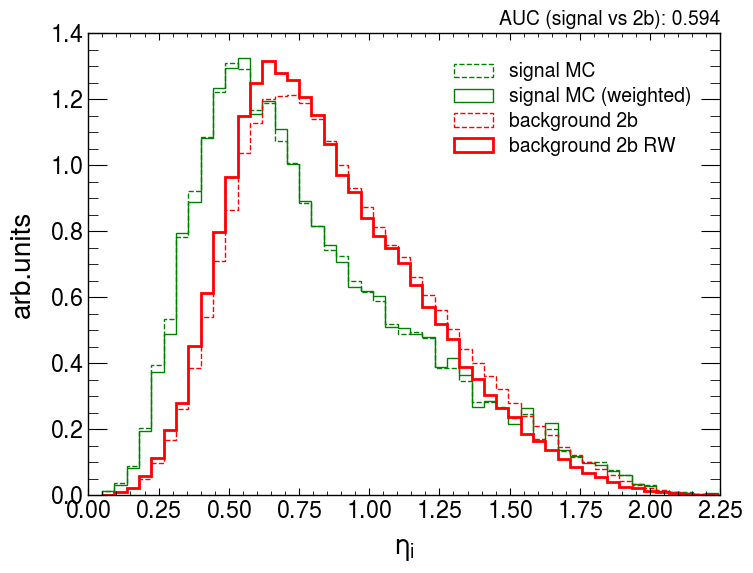

In [251]:
h_sig_raw, be, _ = plt.hist(
    signal_df["eta_i"].values,
    bins=50,
    histtype="step",
    ls='--',
    color='green',
    label="signal MC",
    density=True,
)
h_sig_w, _, _ = plt.hist(
    signal_df["eta_i"].values,
    bins=be,
    histtype="step",
    label="signal MC (weighted)",
    color ='green',
    density=True,
    weights=signal_df['mc_sf'].values
)

h_bkg_raw, _, _  = plt.hist(
    bkg_df["eta_i"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b",
    ls='--',
    density=True,
)
h_bkg_raw, _, _  = plt.hist(
    bkg_df["eta_i"].values,
    bins=be,
    histtype="step",
    color='red',
    label="background 2b RW",
    density=True,
    lw=2,
    weights=bkg_df['NN_weights'].values
)
auc_raw = auc_1d(signal_df['eta_i'],bkg_df['eta_i'],ncuts=100)

# clf = tree.DecisionTreeClassifier()
# X = np.append(signal_df['X_wt_tag'].values, bkg_df['X_wt_tag'].values).reshape(-1,1)
# y = np.append(np.ones(signal_df.shape[0]), np.zeros(bkg_df.shape[0])).reshape(-1,1)
# w = np.append(np.ones(signal_df.shape[0]), bkg_df['NN_weights'].values)
# clf = clf.fit(X, y, sample_weight=w)
# auc = roc_auc_score(y, clf.predict_proba(X)[:,1], sample_weight=w)
plt.title("AUC (signal vs 2b): {:.3f}".format(auc_raw),loc='right',fontsize=14)
# plt.title("AUC (signal vs 2b RW): {:.3f}".format(auc), loc='right', fontsize=14)
plt.legend(loc='best')
plt.xlabel(r'$\eta_{i}$')
plt.ylabel('arb.units')

# Classifier

In [154]:
from xgboost import XGBClassifier

In [155]:
from sklearn.model_selection import train_test_split

In [156]:
X = df_data[features]
y = df_data['class']

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [158]:
model = XGBClassifier()
model.fit(X_train, y_train)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:21:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=36, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [159]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [160]:
pred = model.predict_proba(X_test)

In [161]:
pred_positive = pred[:,1]

In [162]:
auc = roc_auc_score(y_test, pred_positive)

In [163]:
auc

0.7293738306819326

In [164]:
fpr, tpr, _ = roc_curve(y_test, pred_positive)

Text(0, 0.5, 'True Positive Rate')

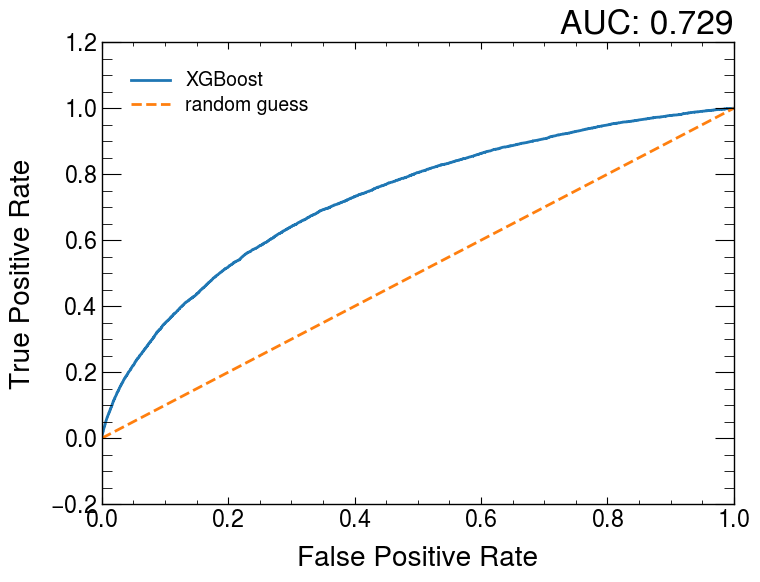

In [165]:
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'XGBoost')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [166]:
from sklearn.metrics import confusion_matrix

In [167]:
pred_label = model.predict(X_test)

In [168]:
pred_label

array([0, 0, 0, ..., 0, 0, 0])

In [169]:
cm = confusion_matrix(y_test, pred_label)

In [170]:
from sklearn.metrics import plot_confusion_matrix

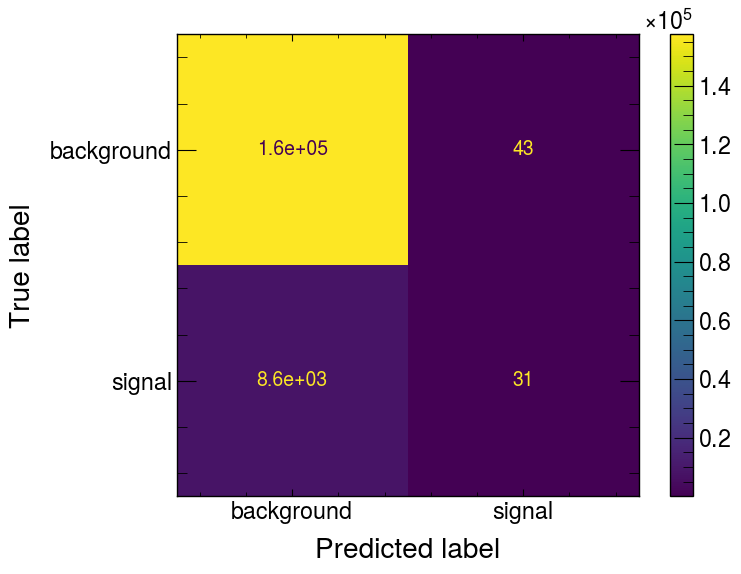

In [171]:
plot_confusion_matrix(model, X_test, y_test,  display_labels=['background', 'signal'])

In [172]:
import seaborn as sns

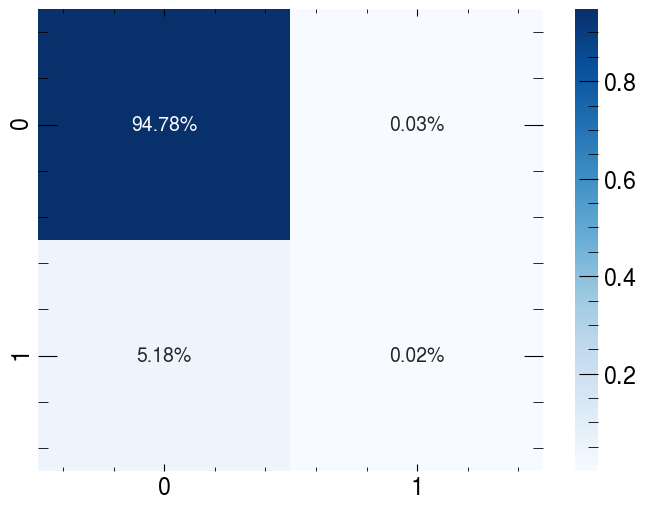

In [173]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

Text(0.5, 1.0, 'XGBoost probability score')

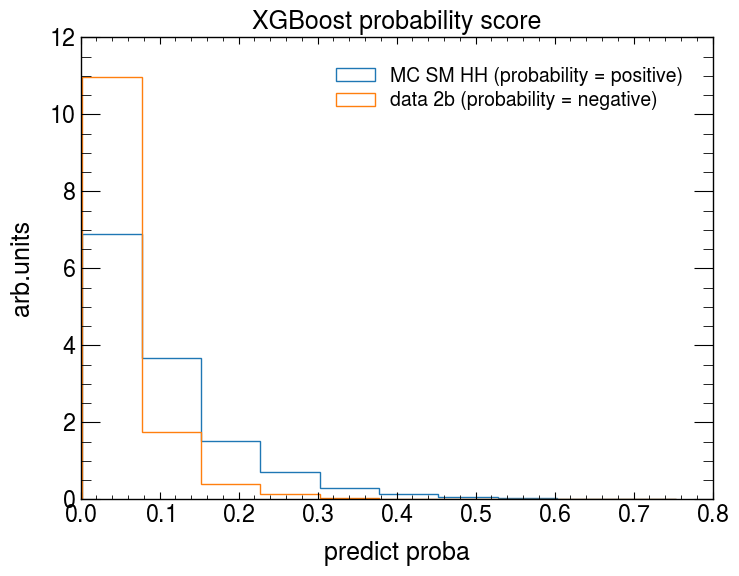

In [174]:
sm_hh_prob=pred[:,1][y_test==1]
data_prob=pred[:,1][y_test==0]

h1, be,_ = plt.hist(sm_hh_prob, bins = 10, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('XGBoost probability score', fontsize=18)

# Class weights

In [175]:
from sklearn.utils import class_weight

In [176]:
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(y_train), y_train))

In [177]:
class_weights

[0.5274522082779748, 9.606735511713934]

In [178]:
n_positive_instances = y_train[y_train==1].shape[0]

In [179]:
n_negative_instances = y_train[y_train==0].shape[0]

In [180]:
r = n_negative_instances / n_positive_instances

In [181]:
r

18.213471023427868

In [182]:
model_balanced = XGBClassifier(scale_pos_weight=r)

In [183]:
model_balanced.fit(X_train, y_train)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:24:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=36, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=18.213471023427868, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [184]:
model_balanced.score(X_train, y_train)

0.7224423818959224

Text(0, 0.5, 'True Positive Rate')

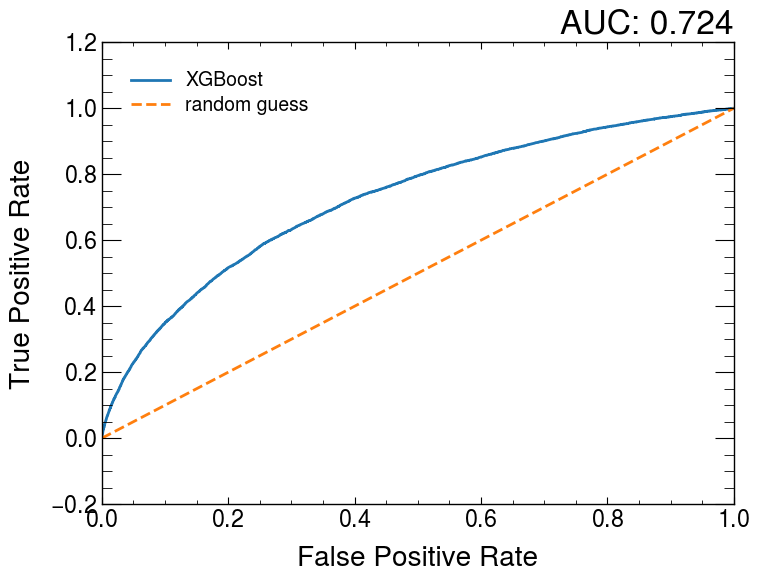

In [185]:
pred = model_balanced.predict_proba(X_test)
pred_positive = pred[:,1]
pred_negative = pred[:,0]
auc = roc_auc_score(y_test, pred_positive)
fpr, tpr, _ = roc_curve(y_test, pred_positive)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'XGBoost')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

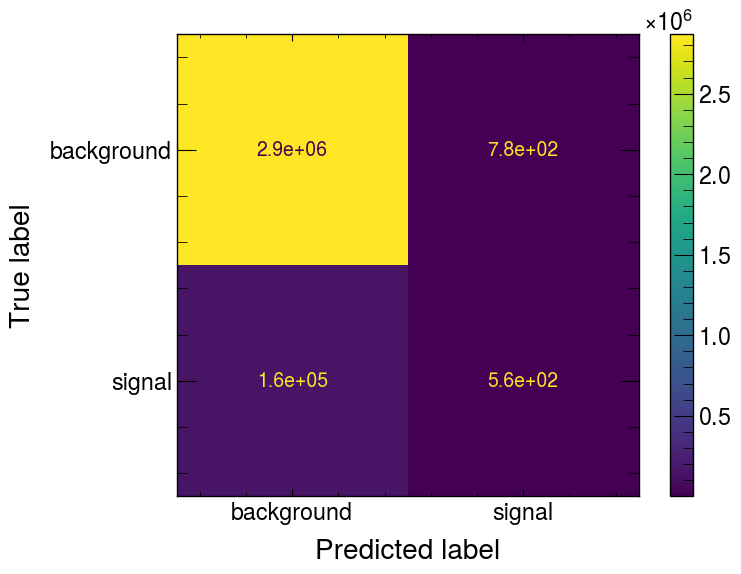

In [186]:
plot_confusion_matrix(model, X_test, y_test, sample_weight=np.ones(len(X_test))*r, display_labels=['background', 'signal'])

In [187]:
sm_hh_prob = pred_positive[y_test==1]
data_prob = pred_positive[y_test==0]

Text(0.5, 1.0, 'XGBoost probability score')

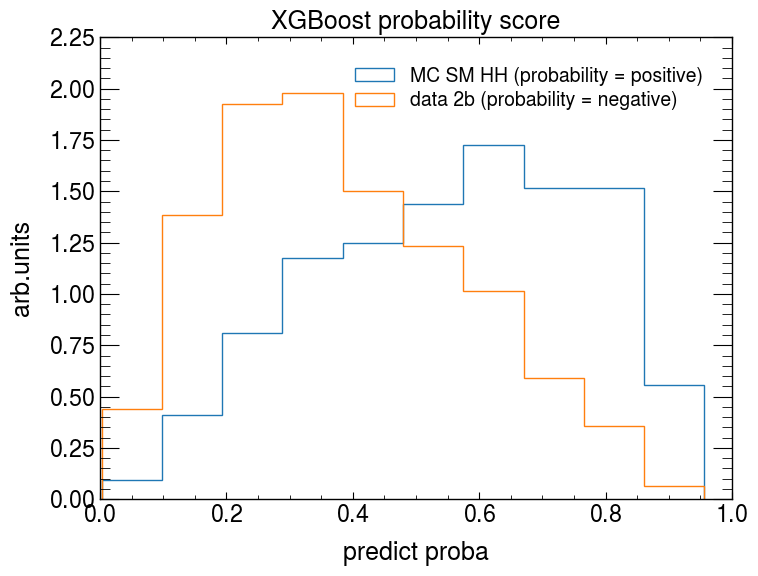

In [188]:
h1, be,_ = plt.hist(sm_hh_prob, bins = 10, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('XGBoost probability score', fontsize=18)

# Instance weights 

In [189]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, list(X.index), test_size=0.4)

In [295]:
df_data['sample_weight'] = np.nan

In [296]:
NN_weights =df_data.loc[df_data['class']==0, 'NN_weights']

In [297]:
df_data.loc[df_data['class'] == 0 , 'sample_weight'] = NN_weights

In [298]:
mc_sf_weights = df_data.loc[df_data['class']==1, 'mc_sf']

In [299]:
df_data.loc[df_data['class']==1, 'sample_weight'] = 1

In [300]:
df_data['class'].value_counts().sum()

415805

In [191]:
df_data['sample_weight2']

0         1.000000
1         1.000000
2         1.000000
3         1.000000
4         1.000000
            ...   
415519    0.003950
415520    0.013105
415521    0.002942
415522    0.004185
415523    0.022320
Name: sample_weight2, Length: 415524, dtype: float64

In [192]:
df_data['sample_weight2'][idx_train]

140565    0.005382
217415    0.010336
195975    0.003590
38917     0.005066
24829     0.002400
            ...   
200640    0.002841
367717    0.005243
79318     0.004129
16117     1.000000
260403    0.005864
Name: sample_weight2, Length: 249314, dtype: float64

In [302]:
df_data.iloc[idx_train, -1]

387461    0.007705
82849     0.006308
179872    0.009231
333824    0.019842
235211    0.011889
            ...   
177306    0.001257
221597    0.001884
82319     0.011966
92897     0.015843
121552    0.007559
Name: sample_weight, Length: 249483, dtype: float64

In [193]:
train_weights = df_data['sample_weight2'][idx_train].values
test_weights = df_data['sample_weight2'][idx_test].values

In [224]:
model_weights = XGBClassifier(verbosity = 1)

In [225]:
model_weights.fit(X_train, y_train, sample_weight=train_weights)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:01:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=36, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=1)

In [226]:
pred_weights = model_weights.predict_proba(X_test)

Text(0.0, 1.0, 'Classifier with NN weights \n(no mc_sf weights)')

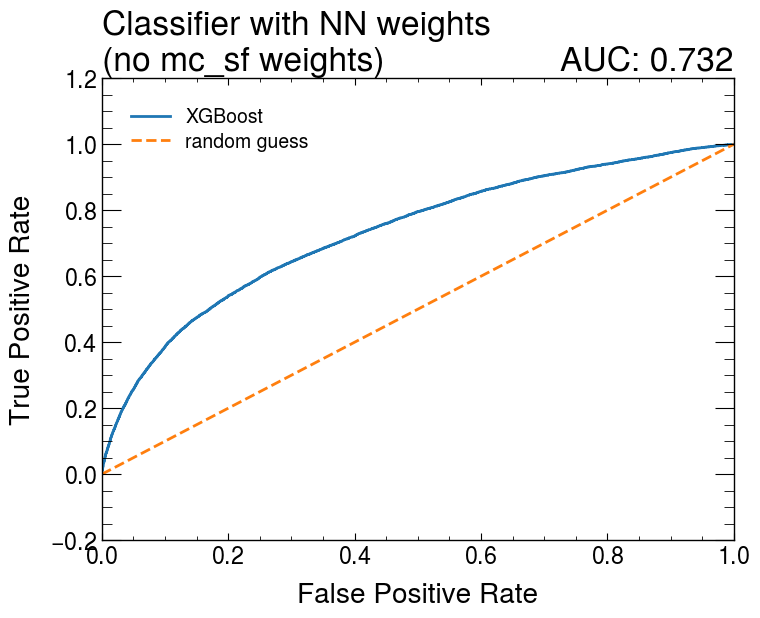

In [227]:
pred_positive = pred_weights[:,1]
pred_negative = pred_weights[:,0]
auc = roc_auc_score(y_test, pred_positive, sample_weight=test_weights)
fpr, tpr, _ = roc_curve(y_test, pred_positive, sample_weight=test_weights)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'XGBoost')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier with NN weights \n(no mc_sf weights)', loc='left')

Text(0.5, 1.0, 'XGBoost probability score')

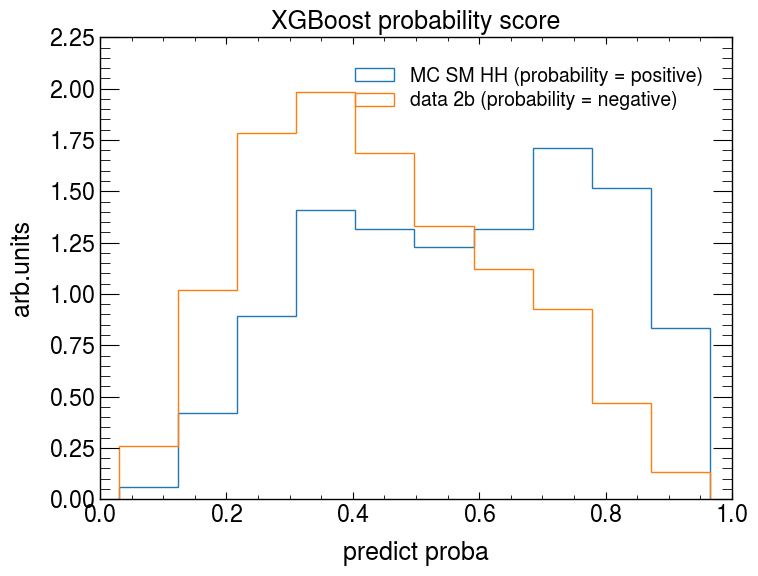

In [228]:
sm_hh_prob = pred_weights[:,1][y_test==1]
data_prob = pred_weights[:,1][y_test==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 10, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('XGBoost probability score', fontsize=18)

# Correcting the number of signal and bkg events

In [204]:
df_data['sample_weight2']

0         1.000000
1         1.000000
2         1.000000
3         1.000000
4         1.000000
            ...   
415519    0.003950
415520    0.013105
415521    0.002942
415522    0.004185
415523    0.022320
Name: sample_weight2, Length: 415524, dtype: float64

In [205]:
Nbkg = df_data.loc[df_data['class']==0,'sample_weight2'].sum()

In [206]:
Nbkg

3197.7428623961637

In [207]:
Nsig = df_data.loc[df_data['class']==1, 'sample_weight2'].sum()

In [208]:
Nsig

21617.0

In [210]:
R = Nbkg/Nsig

In [212]:
df_data['sample_weight3'] = df_data['sample_weight2']

In [213]:
df_data.loc[df_data['class']==1, 'sample_weight3'] = R

In [214]:
df_data['sample_weight3']

0         0.147927
1         0.147927
2         0.147927
3         0.147927
4         0.147927
            ...   
415519    0.003950
415520    0.013105
415521    0.002942
415522    0.004185
415523    0.022320
Name: sample_weight3, Length: 415524, dtype: float64

In [219]:
train_weights = df_data['sample_weight3'][idx_train].values
test_weights = df_data['sample_weight3'][idx_test].values
model_weights3 = XGBClassifier(verbosity = 1)
model_weights3.fit(X_train, y_train, sample_weight=train_weights)
pred_weights3 = model_weights3.predict_proba(X_test)

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:50:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.0, 1.0, 'Classifier with NN weights \n(no mc_sf weights)')

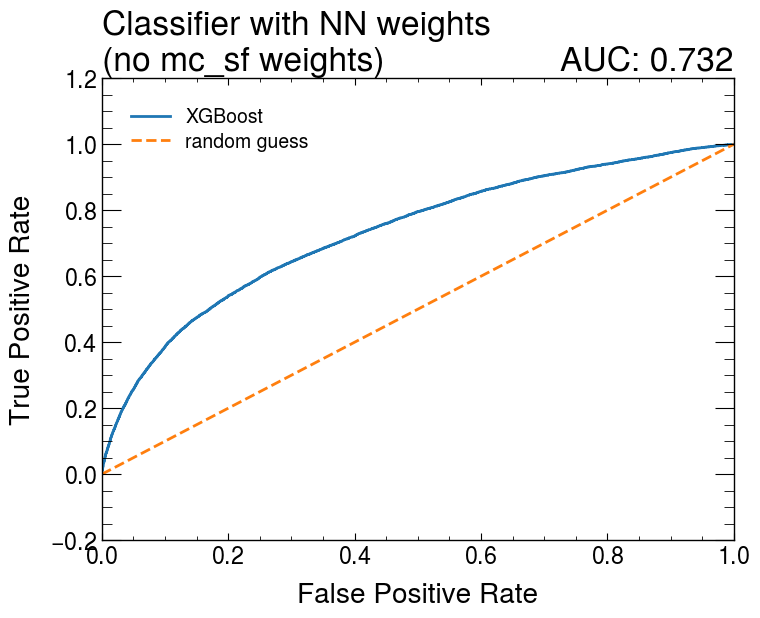

In [220]:
pred_positive = pred_weights3[:,1]
pred_negative = pred_weights3[:,0]
auc = roc_auc_score(y_test, pred_positive, sample_weight=test_weights)
fpr, tpr, _ = roc_curve(y_test, pred_positive, sample_weight=test_weights)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'XGBoost')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier with NN weights \n(no mc_sf weights)', loc='left')

Text(0.5, 1.0, 'XGBoost probability score')

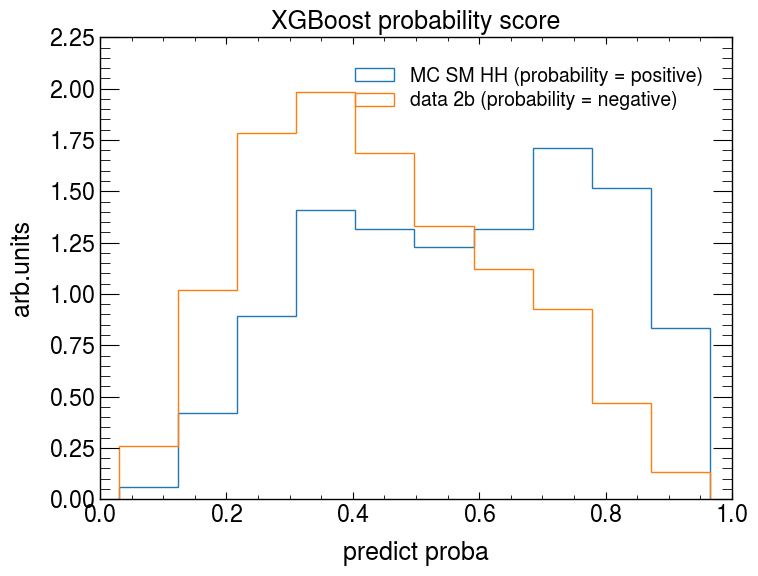

In [221]:
sm_hh_prob = pred_weights3[:,1][y_test==1]
data_prob = pred_weights3[:,1][y_test==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 10, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('XGBoost probability score', fontsize=18)

**Things don't look very ideal, we are not really able to separate out the events that well. However this is a good first step, allowed us to understand alot of things**

**What can we do to improve the situation?** 
- Include more features?
- hyperparameter optimization?
- better training loop?
- better models?

# Adding $\eta_i$ as a feature

In [252]:
features

['Xhh', 'dEta_hh', 'njets', 'X_wt_tag']

In [254]:
X2 = df_data[['Xhh','dEta_hh','njets','X_wt_tag','eta_i']]
y2 = df_data['class']

In [257]:
train_weights = df_data['sample_weight3'][idx_train].values
test_weights = df_data['sample_weight3'][idx_test].values
model_weights3_etai = XGBClassifier(verbosity = 1)
model_weights3_etai.fit(X2.iloc[idx_train], y2.iloc[idx_train], sample_weight=train_weights)
pred_weights3_etai = model_weights3_etai.predict_proba(X2.iloc[idx_test])

/mnt/storage/lborgna/condaenv/py36/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:32:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.0, 1.0, 'Classifier with NN weights \n(no mc_sf weights) + added $\\eta_i$')

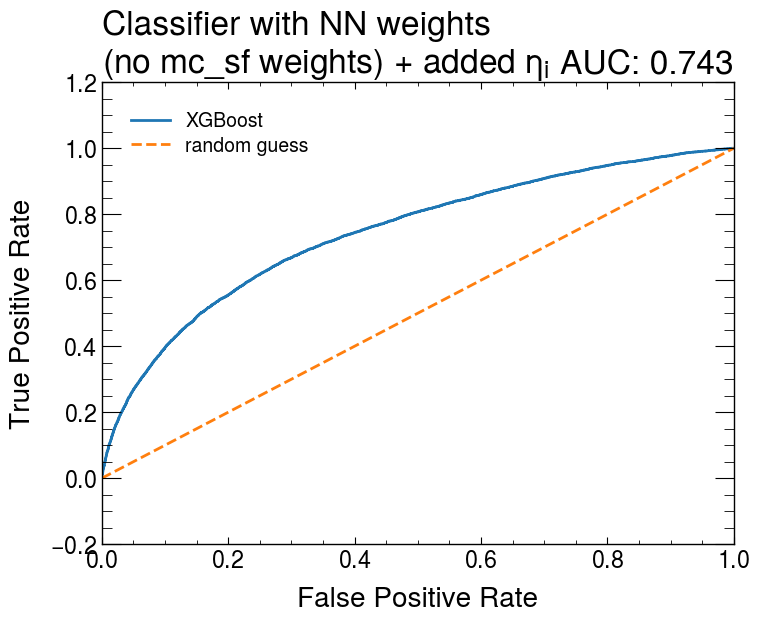

In [258]:
pred_positive = pred_weights3_etai[:,1]
pred_negative = pred_weights3_etai[:,0]
auc = roc_auc_score(y_test, pred_positive, sample_weight=test_weights)
fpr, tpr, _ = roc_curve(y_test, pred_positive, sample_weight=test_weights)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'XGBoost')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier with NN weights \n(no mc_sf weights) + added $\eta_i$', loc='left')

Text(0.5, 1.0, 'XGBoost probability score')

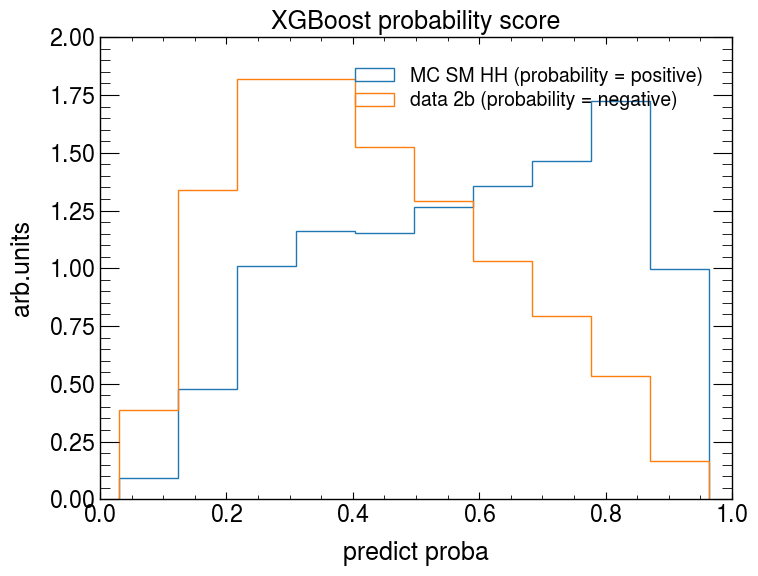

In [259]:
sm_hh_prob = pred_weights3_etai[:,1][y_test==1]
data_prob = pred_weights3_etai[:,1][y_test==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 10, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('XGBoost probability score', fontsize=18)

In [260]:
pred = model_weights3_etai.predict_proba(data[['Xhh','dEta_hh','njets','X_wt_tag','eta_i']].values)

In [263]:
data.kinematic_region.value_counts()

0    393907
Name: kinematic_region, dtype: int64

In [264]:
data['XGB_5D'] = pred[:,1]

In [265]:
df['XGB_5D'] = model_weights3_etai.predict_proba(df[['Xhh','dEta_hh','njets','X_wt_tag','eta_i']])[:,1]

In [266]:
from hh4b_utils.nnt_tools import convert_dataframe_to_nnt

In [267]:
data.loc[data["XGB_5D"] <= 0.25, "XGB_5D_cat"] = 1
data.loc[(data["XGB_5D"] > 0.25) & (data["XGB_5D"] <= 0.5), "XGB_5D_cat"] = 2
data.loc[(data["XGB_5D"] > 0.5) & (data["XGB_5D"] <= 0.75), "XGB_5D_cat"] = 3
data.loc[data["XGB_5D"] > 0.75, "XGB_5D_cat"] = 4

In [268]:
df.loc[df["XGB_5D"] <= 0.25, "XGB_5D_cat"] = 1
df.loc[(df["XGB_5D"] > 0.25) & (df["XGB_5D"] <= 0.5), "XGB_5D_cat"] = 2
df.loc[(df["XGB_5D"] > 0.5) & (df["XGB_5D"] <= 0.75), "XGB_5D_cat"] = 3
df.loc[df["XGB_5D"] > 0.75, "XGB_5D_cat"] = 4

In [269]:
convert_dataframe_to_nnt(
    data,
    "/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_16_NN_100_bootstraps_XGB_5D.root",
)

100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


In [270]:
convert_dataframe_to_nnt(
    df, "/mnt/storage/lborgna/NNT/MDR_VEC/mc/mc16a_2b_shiftKR_lshi_XGB_5D.root"
)

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


# Neural Network (SKLEARN doesn't work) 

In [278]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [272]:
from sklearn.preprocessing import StandardScaler

In [273]:
scaler = StandardScaler()

In [274]:
X2

Xhh   dEta_hh  njets  X_wt_tag     eta_i
0       1.202672  0.483921      4  5.494578  0.477902
1       0.346642  0.383857      4  4.397948  1.174174
2       0.709134  0.606902      5  2.470833  1.235871
3       0.556196  1.318419      4  5.872308  0.745159
4       1.538856  0.958484      5  3.804266  0.712757
...          ...       ...    ...       ...       ...
415519  0.522731  0.412735      4  3.304543  1.263067
415520  1.123110  0.419846      5  2.707029  1.706299
415521  1.481408  1.323396      4  5.935482  1.426903
415522  0.685950  1.271887      4  4.023303  1.194547
415523  1.156309  0.246814      5  2.287746  1.060928

[415524 rows x 5 columns]

In [275]:
X_train_sc = scaler.fit_transform(X2.iloc[idx_train])
X_test_sc =scaler.transform(X2.iloc[idx_test])

In [283]:
from keras.utils import to_categorical
y_train_onehot = to_categorical(y2.iloc[idx_train])

Using TensorFlow backend.


In [297]:
model = Sequential()
model.add(Dense(20, input_dim=5, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [298]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [299]:
history = model.fit(
    X_train_sc, y_train_onehot, epochs=50, sample_weight=train_weights, batch_size = 500
)

  ...
    to  
  ['...']
Train on 249314 samples
Epoch 1/50
249314/249314 [==============================] - 1s 6us/sample - loss: 0.0094 - accuracy: 0.5785
Epoch 2/50
249314/249314 [==============================] - 1s 4us/sample - loss: 0.0092 - accuracy: 0.6180
Epoch 3/50
249314/249314 [==============================] - 1s 4us/sample - loss: 0.0091 - accuracy: 0.6195
Epoch 4/50
249314/249314 [==============================] - 1s 4us/sample - loss: 0.0091 - accuracy: 0.6265
Epoch 5/50
249314/249314 [==============================] - 1s 4us/sample - loss: 0.0091 - accuracy: 0.6224
Epoch 6/50
249314/249314 [==============================] - 1s 4us/sample - loss: 0.0091 - accuracy: 0.6239
Epoch 7/50
249314/249314 [==============================] - 1s 4us/sample - loss: 0.0091 - accuracy: 0.6254
Epoch 8/50
249314/249314 [==============================] - 1s 4us/sample - loss: 0.0091 - accuracy: 0.6254
Epoch 9/50
249314/249314 [==============================] - 1s 4us/sample - loss: 0.009

In [300]:
pred_NN = model.predict(X_test_sc)

Text(0.0, 1.0, 'Classifier with NN weights \n(no mc_sf weights) + added $\\eta_i$')

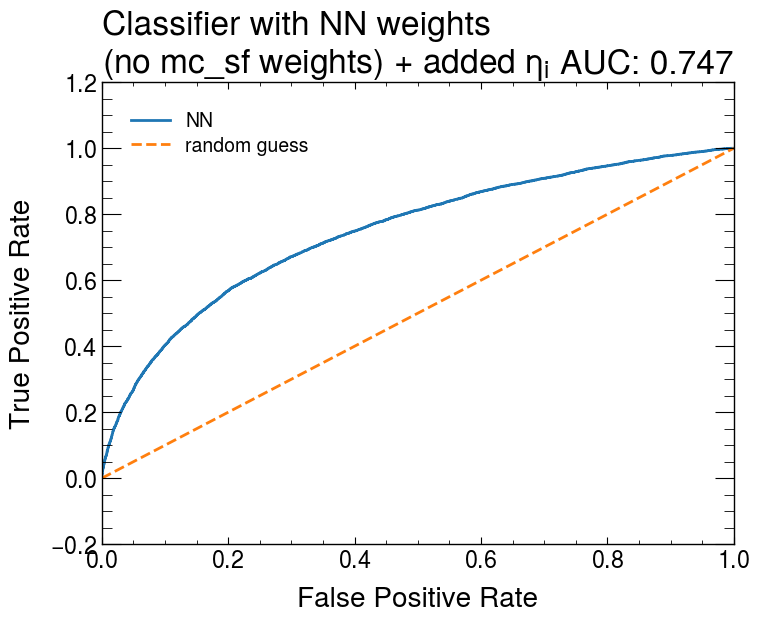

In [301]:
pred_positive = pred_NN[:,1]
pred_negative = pred_NN[:,0]
auc = roc_auc_score(y_test, pred_positive, sample_weight=test_weights)
fpr, tpr, _ = roc_curve(y_test, pred_positive, sample_weight=test_weights)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'NN')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier with NN weights \n(no mc_sf weights) + added $\eta_i$', loc='left')

Text(0.5, 1.0, 'NN probability score')

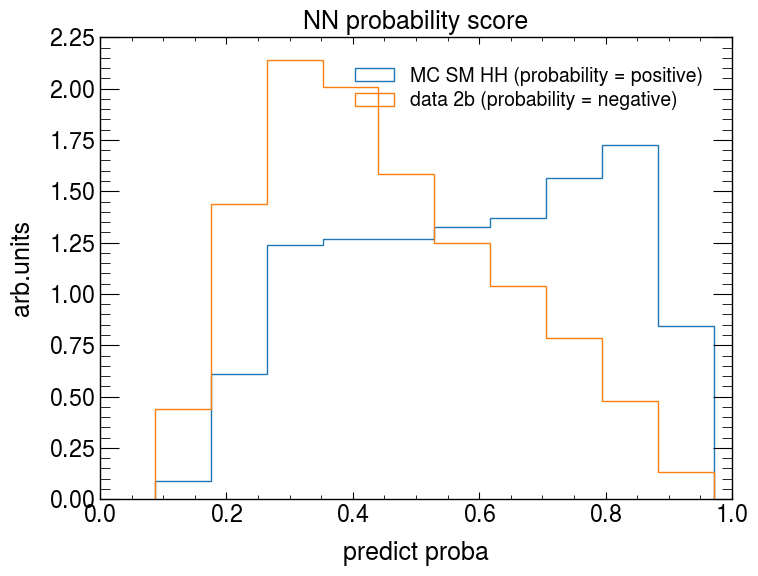

In [302]:
sm_hh_prob = pred_NN[:,1][y_test==1]
data_prob = pred_NN[:,1][y_test==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 10, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('NN probability score', fontsize=18)

# LETS BRING OUT THE BIG GUNS

In [222]:
import tensorflow as tf

In [223]:
tf.__version__

'2.1.0'

## Ignore negative monte carlo weights

In [240]:
df_data_reduced = df_data.loc[df_data['sample_weight']>=0]

In [241]:
X_r = df_data_reduced[features]
y_r = df_data_reduced['class']

In [242]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_r, y_r, list(X.index), test_size=0.4)

In [243]:
mc_sf_weights = df_data_reduced.loc[df_data_reduced['class']==1, 'mc_sf']
df_data_reduced.loc[df_data_reduced['class']==1, 'sample_weight'] = mc_sf_weights

In [244]:
train_weights = df_data.iloc[idx_train, -1].values
test_weights = df_data.iloc[idx_test, -1].values

In [247]:
model_weights2 = XGBClassifier(scale_pos_weight=r, verbosity = 1)

In [248]:
model_weights2.fit(X_train, y_train, sample_weight=train_weights)

[14:49:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=36, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=18.31225786455912, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=1)

In [249]:
pred_weights2 = model_weights.predict_proba(X_test)

Text(0.0, 1.0, 'Classifier with NN weights \n(no mc_sf weights)')

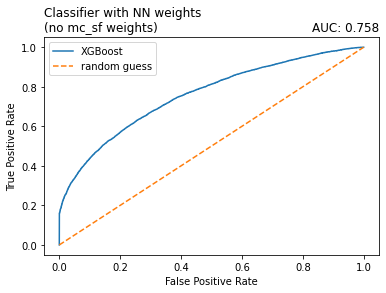

In [250]:
pred_positive = pred_weights2[:,1]
pred_negative = pred_weights2[:,0]
auc = roc_auc_score(y_test, pred_positive, sample_weight=test_weights)
fpr, tpr, _ = roc_curve(y_test, pred_positive, sample_weight=test_weights)
x_fpr = np.linspace(0, 1, 50)
y_tpr = np.linspace(0, 1, 50)
plt.plot(fpr, tpr, ls='-', label = 'XGBoost')
plt.plot(x_fpr, y_tpr, ls='--',label = 'random guess')
plt.legend()
plt.title('AUC: {:.3f}'.format(auc), loc='right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier with NN weights \n(no mc_sf weights)', loc='left')

Text(0.5, 1.0, 'XGBoost probability score')

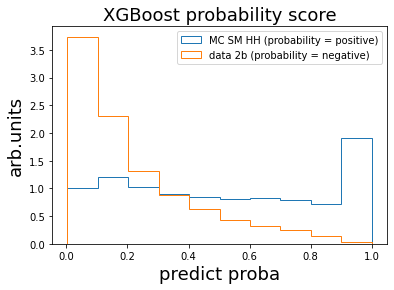

In [251]:
sm_hh_prob = pred_weights2[:,1][y_test==1]
data_prob = pred_weights2[:,1][y_test==0]
h1, be,_ = plt.hist(sm_hh_prob, bins = 10, histtype='step',label='MC SM HH (probability = positive)', density= True)
h2,_,_ = plt.hist(data_prob, bins = be, histtype='step', label = 'data 2b (probability = negative)', density = True)
plt.legend()
plt.xlabel('predict proba', fontsize=18)
plt.ylabel('arb.units', fontsize = 18)
plt.title('XGBoost probability score', fontsize=18)